# IE 423 Quality Engineering
# Project Part 1
# Ahmet Emre Gökalp
# Necdet Sinan Parlar

We start by importing necessary libraries for our study. Pandas for manipulating data and matplotlib for plotting.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

First thing to do is add the data to our workplace. We chose to work with wide data format, because it is easy to read and interpret.

In [99]:
df = pd.read_csv("all_ticks_wide.csv.gz")

We convert the timestamp column to pandas DateTime since it is more accurate and much faster than Python's DateTime object. Data is already chronologically ordered in wide format. Time zones are also eliminated for convenience.

In [100]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)


The stocks we chose to work with are: 'THYAO', 'PGSUS', 'TTKOM', 'TCELL', 'ISCTR', 'KCHOL'

We work wth the data between the dates [2015-07-23 15:00:00, 2019-07-23 15:00:00]. For convenience, we get rid of irrelevant stocks, and prices which are not between the specified dates. Also resetted the indices.

In [105]:
df = df[['timestamp','THYAO', 'PGSUS', 'TTKOM', 'TCELL', 'ISCTR', 'AEFES']]
df = df[(df['timestamp'] >=  pd.to_datetime('2015-07-23 15:00:00')) & (df['timestamp'] <=  pd.to_datetime('2019-07-23 15:00:00'))]
df = df.reset_index(drop=True)

Boxplotted the values from the last price of each month for each stock.

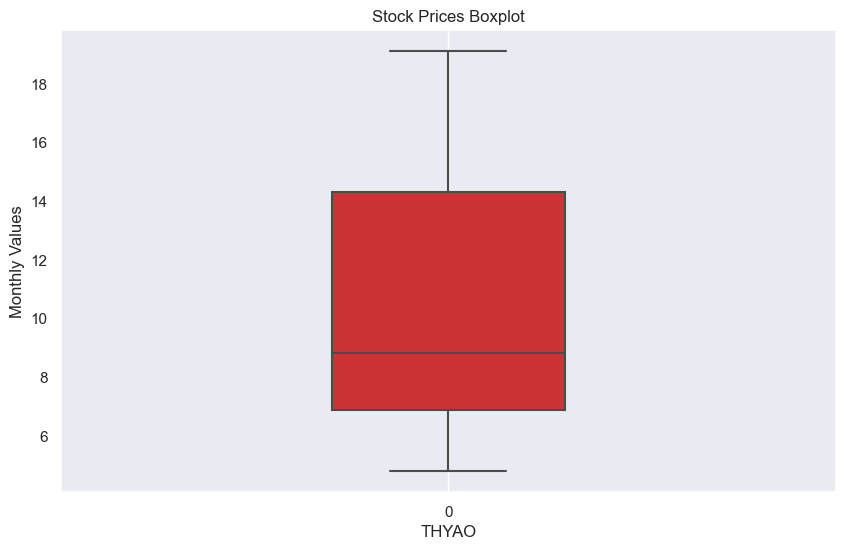

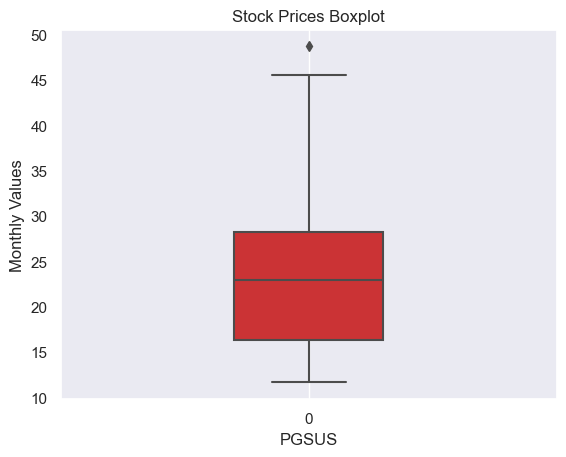

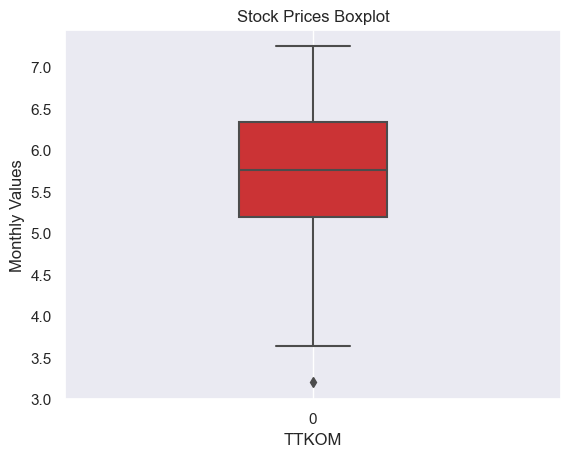

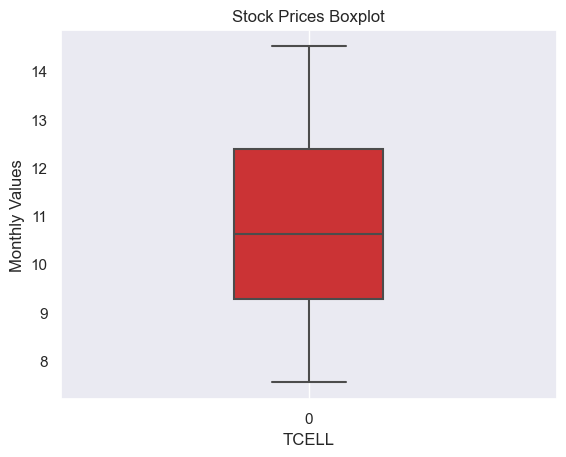

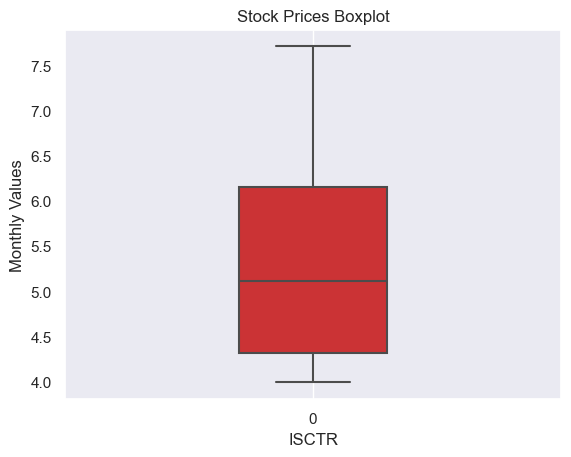

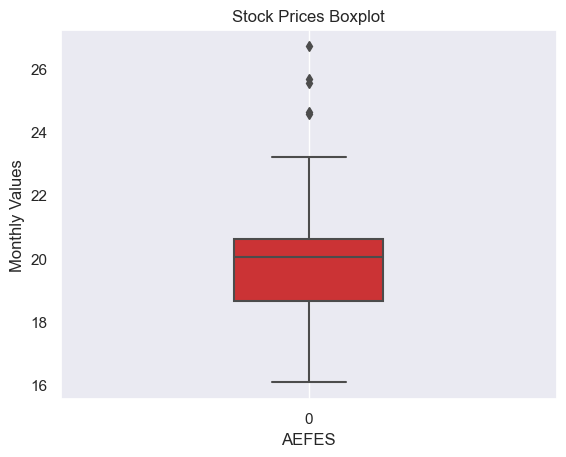

In [106]:

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

stocks = ['THYAO', 'PGSUS', 'TTKOM', 'TCELL', 'ISCTR', 'AEFES']

# Plot the average of each mont boxplot for the selected stocks
monthly_last_value = df.resample('M', on = 'timestamp').last()

for stocks in stocks:
    sns.boxplot(data=monthly_last_value[stocks], palette="Set1", width= 0.3)
    plt.title("Stock Prices Boxplot")
    plt.xlabel(stocks)
    plt.ylabel('Monthly Values')
    plt.grid()
    plt.show



Now, we find outliers using the quantile and IQR value.

In [141]:
def detect_outliers(stock, df):
    Q1 = df[stock].quantile(0.25)
    Q3 = df[stock].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Use boolean masking to identify outliers
    outliers = df[(df[stock] < lower_bound) | (df[stock] > upper_bound)][stock]
    
    return outliers

for stock in ['THYAO', 'PGSUS', 'TTKOM', 'TCELL', 'ISCTR', 'AEFES']:
    print(detect_outliers(stock,monthly_last_value))


Series([], Freq: M, Name: THYAO, dtype: float64)
timestamp
2019-07-31    48.72
Freq: M, Name: PGSUS, dtype: float64
timestamp
2018-10-31    3.2
Freq: M, Name: TTKOM, dtype: float64
Series([], Freq: M, Name: TCELL, dtype: float64)
Series([], Freq: M, Name: ISCTR, dtype: float64)
timestamp
2018-01-31    26.6902
2018-02-28    24.6194
2018-03-31    25.6739
2018-04-30    25.5397
2018-05-31    24.5557
Freq: M, Name: AEFES, dtype: float64


There is 1 outlier in PGSUS, 1 outlier in TTKOM, and 5 outliers in AEFES data.

In order to investigate what may have caused these outliers we compare our data with the Google Trends Data. Start by importing the data.

In [150]:
df_google_ttkom = pd.read_csv("TTKOM.csv", names=['Date','Data'])
df_google_aefes = pd.read_csv("AEFES.csv", names=['Date','Data'])
df_google_pgsus = pd.read_csv("PGSUS.csv", names=['Date','Data'])

df_google_ttkom = df_google_ttkom.iloc[2:]
df_google_ttkom.reset_index(drop=True, inplace=True)

df_google_aefes = df_google_aefes.iloc[2:]
df_google_aefes.reset_index(drop=True, inplace=True)

df_google_pgsus = df_google_pgsus.iloc[2:]
df_google_pgsus.reset_index(drop=True, inplace=True)


# TTKOM Comparison

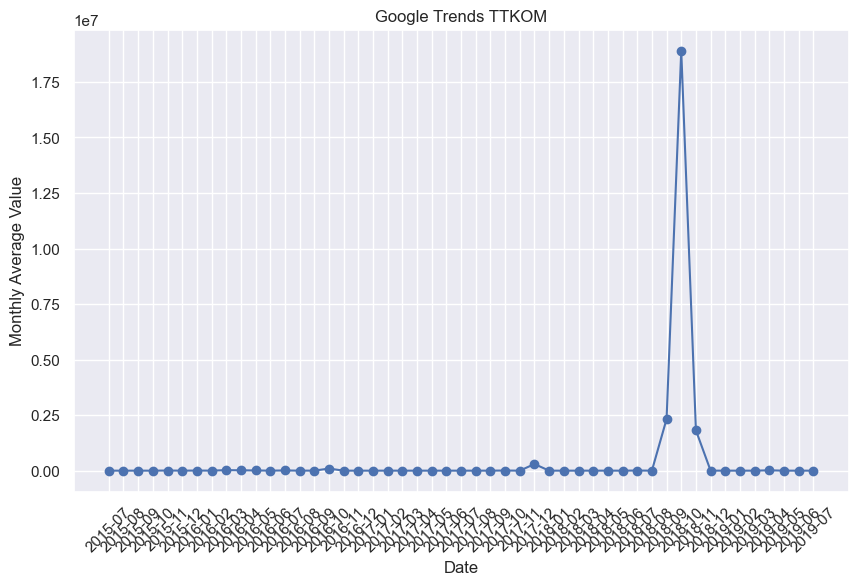

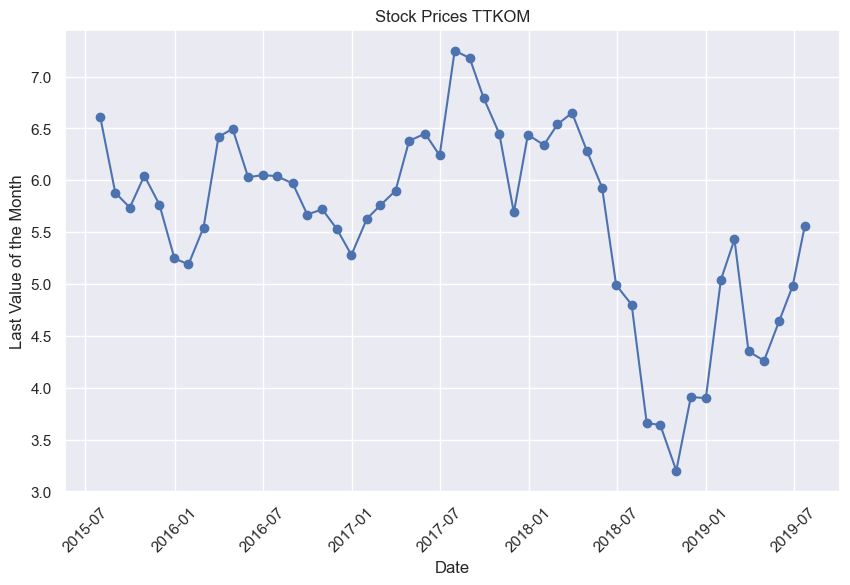

In [169]:
# Convert the 'Date' column to a datetime type if it's not already
df_google_ttkom['Date'] = pd.to_datetime(df_google_ttkom['Date'])

# Group the data by month and calculate the mean for each month
monthly_data = df_google_ttkom.groupby(df_google_ttkom['Date'].dt.to_period('M'))['Data'].mean().reset_index()
monthly_data['Date'] = monthly_data['Date'].dt.strftime('%Y-%m')

# Define a common figure size
fig_size = (10, 6)

# Create a line plot for the monthly data (Google Trends TTKOM)
plt.figure(figsize=fig_size)  # Use the same figure size for both plots
plt.plot(monthly_data['Date'], monthly_data['Data'], marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Monthly Average Value")
plt.title("Google Trends TTKOM")
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the first plot
plt.show()

# Now plotting the stock price values (Stock Prices TTKOM).
plt.figure(figsize=fig_size)  # Use the same figure size for both plots

# Plot the second graph
plt.plot(monthly_last_value['timestamp'], monthly_last_value['TTKOM'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Last Value of the Month")
plt.title("Stock Prices TTKOM")
plt.xticks(rotation=45)

# Show the second plot
plt.show()


We can quiet easily see a correlation between graphs but a negative correlation. TTKOM price has its lowest value in its most searched month which is October 2018, as we expected since it was already detected as an outlier. 

For Turk Telekom, this incident was entirely related to corruption. When the background of this is investigated, it dates back to 2013, but to summarize briefly, a company named OTAS (Oger Telecom) was going to transfer Turk Telecom to a joint venture company formed by the three largest banks in Turkey, by the decision of the state on August 30, 2018. The main reason for this is that since OTAS could not repay the 4.75 billion dollar loan it received with the support of the state when purchasing Turk Telekom, it was decided to take back OTAS through a joint venture company that would be established by taking over the collateral shares of the banks providing these loans. It made a loss in the third quarter due to the depreciation of the Turkish lira and foreign exchange open positions in recent years, and this affected the first month of the 4th quarter, which caused the outlier in the chart.

The following is a paragraph from a news that explains this situation.

'Türk Telekom resmen devredildi, yapılan son dakika açıklamasıyla Akbank, Garanti Bankası ve İş Bankası Türk Telekom’un çoğunluğuna sahip oldu . Açıklama Türk Telekom tarafından KAP’a yapıldı. Lübnanlı Hariri ailesinin doğrudan ve Saudi Telecom Company’nin dolaylı ortak olduğu OTAŞ, Türk Telekom hisselerini teminat göstererek 2013 yılında aldığı 4.75 milyar dolar tutarındaki krediyi geri ödeyemedi. Kreditör bankalar bunun üzerine teminat hisseleri devralarak kuracakları bir SPV’ye yerleştirmeye karar verdi.'
https://www.sozcu.com.tr/2018/ekonomi/turk-telekom-resmen-devredildi-2597301/

# PGSUS Comparison 

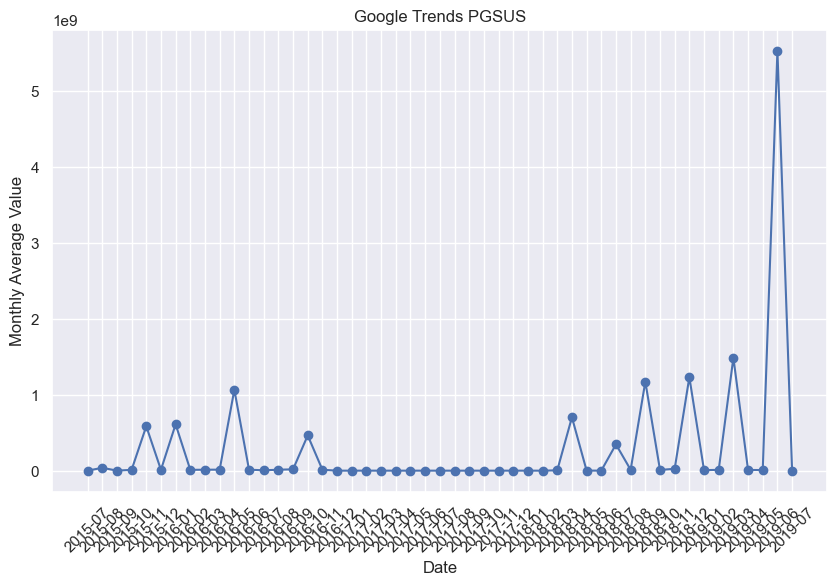

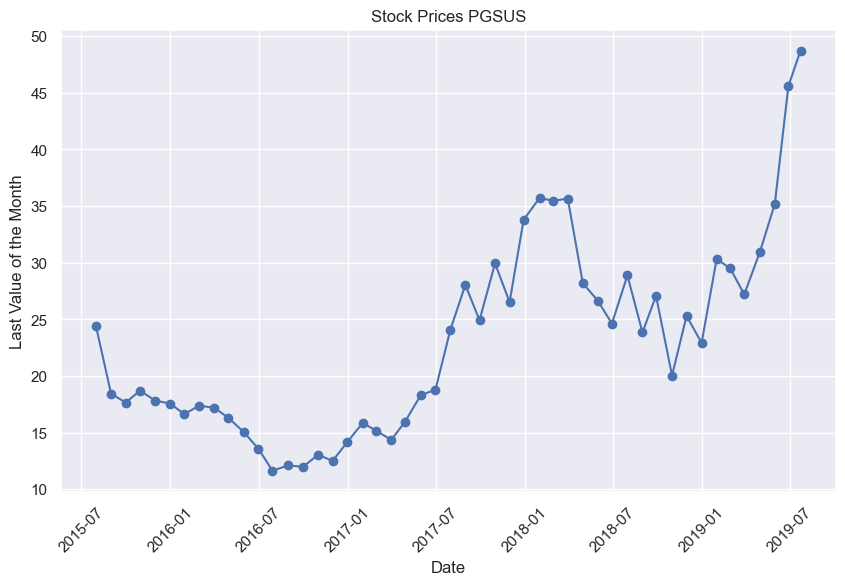

In [168]:
# Convert the 'Date' column to a datetime type if it's not already
df_google_pgsus['Date'] = pd.to_datetime(df_google_pgsus['Date'])

# Group the data by month and calculate the mean for each month
monthly_data = df_google_pgsus.groupby(df_google_pgsus['Date'].dt.to_period('M'))['Data'].mean().reset_index()
monthly_data['Date'] = monthly_data['Date'].dt.strftime('%Y-%m')

# Define a common figure size
fig_size = (10, 6)

# Create a line plot for the monthly data (Google Trends PGSUS)
plt.figure(figsize=fig_size)  # Use the same figure size for both plots
plt.plot(monthly_data['Date'], monthly_data['Data'], marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Monthly Average Value")
plt.title("Google Trends PGSUS")
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the first plot
plt.show()

# Now plotting the stock price values (Stock Prices PGSUS).
plt.figure(figsize=fig_size)  # Use the same figure size for both plots

# Plot the second graph
plt.plot(monthly_last_value['timestamp'], monthly_last_value['PGSUS'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Last Value of the Month")
plt.title("Stock Prices PGSUS")
plt.xticks(rotation=45)

# Show the second plot
plt.show()


There is a positive correlation between google search frequency and stock prices. The oultier we detected, which can also be seen simply from the graphs is 07/2019. For this specific date we could not find any relevant event that may have caused this spike in Google search frequency and stock prices. It could be related with a promotion that Pegasus provided for its customers or with the amount of flights happened in that month that significantly increased the companies' revenue.

# AEFES Comparison

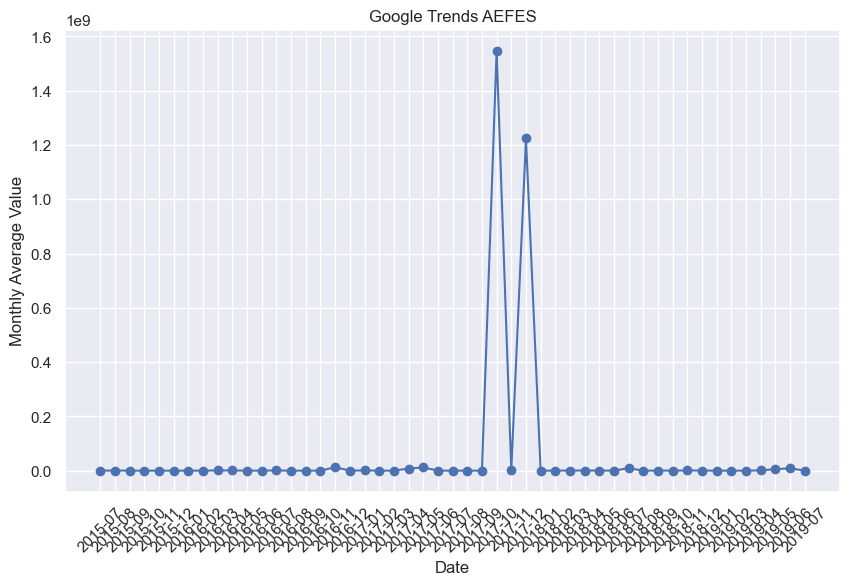

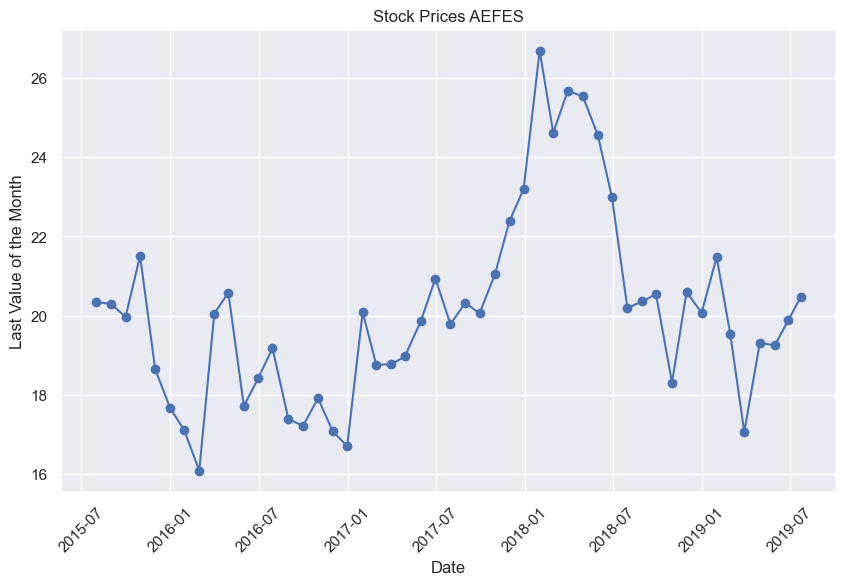

In [170]:
# Convert the 'Date' column to a datetime type if it's not already
df_google_aefes['Date'] = pd.to_datetime(df_google_aefes['Date'])

# Group the data by month and calculate the mean for each month
monthly_data = df_google_aefes.groupby(df_google_aefes['Date'].dt.to_period('M'))['Data'].mean().reset_index()
monthly_data['Date'] = monthly_data['Date'].dt.strftime('%Y-%m')

# Define a common figure size
fig_size = (10, 6)

# Create a line plot for the monthly data (Google Trends AEFES)
plt.figure(figsize=fig_size)  # Use the same figure size for both plots
plt.plot(monthly_data['Date'], monthly_data['Data'], marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Monthly Average Value")
plt.title("Google Trends AEFES")
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()

# Now plotting the stock price values (Stock Prices AEFES).
plt.figure(figsize=fig_size)  # Use the same figure size for both plots

# Plot the second graph with tighter x-axis label rotation
plt.plot(monthly_last_value['timestamp'], monthly_last_value['AEFES'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Last Value of the Month")
plt.title("Stock Prices AEFES")

# Adjust the x-axis label rotation
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the second plot
plt.show()



There is a positive correlation between google search frequency and stock prices. 
We think there are two main reasons why Efes stocks increased in the first 5 months of 2018. The first of these is that Efes' domestic growth and market share lost approximately 6 percent of its value due to increased taxes at that time. The reason for this is that with increasing taxes, people started making and consuming beer at home. Anadolu Efes Group, which analyzed this situation, made Frankfurt-based investments in Germany and increased its overall growth to nine percent in the specified periods, which is observed as an outlier in the chart due to the small quantile range, which is the second reason.

#  Summary

In all three studies, we observed a correlation between stock prices and Google Trends data. This correlation is not surprising, as stock prices are influenced by significant social and sectoral events. It is natural to see an increase in google search frequencies during times of important events that impact these selected companies, which have a high level of influence and affect the lives of many people in our country.